# Лабораторна робота 4. Суханевич Олександри ФФ-31мн

## 1.  Завдання щодо генерації текстів на базі RNN

**Створимо просту нейронну мережу для генерації тексту на основі символів.**

Початковим етапом є завантаження текстового файлу та його обробка. Текст зчитується у вигляді суцільного рядка, приводиться до нижнього регістру, а також очищується від непотрібних переносів рядків. Довжина тексту обмежується максимальною кількістю символів, що дозволяє контролювати обсяг даних для навчання. Далі визначається унікальний набір символів, що використовуються у тексті, і кожному символу призначається унікальний індекс.

Для навчання моделі генеруються послідовності фіксованої довжини та їх цільові символи. У послідовності береться певна кількість символів (зазначена у *sequence_length*), а цільовим значенням є наступний символ після цієї послідовності. Послідовності відбираються із заданим кроком, щоб збільшити обсяг даних для тренування. Далі послідовності перетворюються на числові дані, використовуючи *one-hot* кодування, де кожен символ в послідовності представляється як вектор довжини, що дорівнює кількості унікальних символів. Аналогічно, цільові значення також перетворюються у *one-hot* вектори.

Наступним кроком є створення моделі. Нейронна мережа побудована з одного шару *Dense*, який має стільки виходів, скільки є унікальних символів у тексті. Активаційна функція на виході — *softmax*, що дозволяє отримати ймовірності для кожного символу. Оптимізація мережі здійснюється за допомогою алгоритму *RMSprop*, а функція втрат визначена як *categorical_crossentropy*, що є стандартною функцією для задач багатокласової класифікації.

Процес навчання здійснюється у декілька епох, причому застосовується динамічне зменшення швидкості навчання за допомогою планувальника. На початкових епохах швидкість навчання залишається незмінною, а згодом вона зменшується вдвічі для стабілізації процесу навчання та покращення результатів. Після навчання модель здатна передбачати наступний символ у тексті, генеруючи текст посимвольно.

Генерація нового тексту починається з випадково вибраної послідовності символів з вихідного тексту. Для кожного кроку модель отримує вхідний вектор, що відповідає послідовності попередніх символів, і прогнозує ймовірності для кожного можливого символу. Використовується метод *temperature scaling*, який контролює "впевненість" моделі у своїх прогнозах: низьке значення *temperature* робить текст більш детермінованим і прогнозованим, а високе значення додає більше випадковості. Наступний символ обирається відповідно до розподілу ймовірностей, отриманого на виході *softmax*. Вибраний символ додається до згенерованого тексту, а початкова послідовність зміщується на один символ вперед, замінюючи найстаріший символ новим. Процес повторюється задану кількість разів, доки не буде згенеровано повний текст.



In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import os

def determine_batch_size(num_samples, max_batch_size=128):
    """
    Автоматичний вибір batch_size на основі кількості даних.
    Чим більше даних, тим більший batch_size.
    """
    if num_samples < 1000:
        return 16
    elif num_samples < 5000:
        return 32
    elif num_samples < 20000:
        return 64
    else:
        return min(max_batch_size, 128)

# 1. Завантаження локального текстового файлу та підготовка даних
def load_and_preprocess(file_path, sequence_length=40, step=3, maxlen=100000):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Incorrect file path: {file_path} ")

    with open(file_path, encoding="utf-8") as file:
        text = file.read().lower().replace("\n", " ")

    selected_len = len(text)
    if selected_len > maxlen:
      selected_len = maxlen
    text = text[:selected_len]

    print(f"Text length: {len(text)}")

    # Унікальні символи та їх індексація
    chars = sorted(set(text))
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for idx, char in enumerate(chars)}

    # Генерація послідовностей та цільових символів
    sequences, targets = [], []
    for i in range(0, len(text) - sequence_length, step):
        sequences.append(text[i:i + sequence_length])
        targets.append(text[i + sequence_length])
    print(f"Total sequences: {len(sequences)}")

    return text, chars, char_to_idx, idx_to_char, sequences, targets

def vectorize_data(sequences, targets, char_to_idx, sequence_length, num_chars):
    X = np.zeros((len(sequences), sequence_length, num_chars), dtype=np.bool_)
    y = np.zeros((len(sequences), num_chars), dtype=np.bool_)
    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X[i, t, char_to_idx[char]] = 1
        y[i, char_to_idx[targets[i]]] = 1
    return X, y

# 2. Побудова моделі
def create_model(sequence_length, num_chars, lr=1e-2):
    model = Sequential([
        Input(shape=(sequence_length, num_chars)),
        Dense(num_chars, activation="softmax")
    ])
    model.compile(
        # optimizer=Adam(learning_rate=lr),
        optimizer=RMSprop(learning_rate=lr),
        loss="categorical_crossentropy"
    )
    return model

# 3. Функція для зразкового вибору наступного символу
def select_next_character(preds, temperature=1.0):
    # return np.argmax(predictions)
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


# 4. Генерація тексту на основі навченої моделі
def generate_text(model, text, char_to_idx, idx_to_char, sequence_length, num_chars_to_generate=400, temp=1.0):
    start_idx = random.randint(0, len(text) - sequence_length - 1)
    seed_text = text[start_idx:start_idx + sequence_length]
    generated = seed_text

    for _ in range(num_chars_to_generate):
        x_pred = np.zeros((1, sequence_length, len(char_to_idx)))
        for t, char in enumerate(seed_text):
            x_pred[0, t, char_to_idx[char]] = 1.0

        predictions = model.predict(x_pred, verbose=0)[0]
        next_idx = select_next_character(predictions, temp)
        next_char = idx_to_char[next_idx]

        generated += next_char
        seed_text = seed_text[1:] + next_char
    return generated

# 5. Основний цикл навчання
file_path = "nestayko-vsevolod-zinoviyovych-toreadory-z-vasiukivky914.txt"
sequence_length = 40
step = 3

data_text, chars, char_to_idx, idx_to_char, sequences, targets = load_and_preprocess(file_path, sequence_length, step, 100000)
X, y = vectorize_data(sequences, targets, char_to_idx, sequence_length, len(chars))

# Автоматичний вибір batch_size
num_samples = len(X)
batch_size = determine_batch_size(num_samples)
print(f"Batch size automatically set to: {batch_size}")

model = create_model(sequence_length, len(chars), 0.01)
model.summary()

def lr_scheduler(epoch, lr):
  if epoch < 4:
    return lr
  else:
    return lr / 2

history = model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=5,
    callbacks=[callbacks.LearningRateScheduler(lr_scheduler)]
)

temperature = 0.1
print("\n--- Generated Text ---")
# print(generate_text(model, data_text, char_to_idx, idx_to_char, sequence_length, 200, temperature))

Text length: 100000
Total sequences: 33320
Batch size automatically set to: 128


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                       │ (None, 256)                 │         315,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 51)                  │          13,107 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,499 (1.25 MB)

 Trainable params: 328,499 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 70s 259ms/step - loss: 3.2055 - learning_rate: 0.0100
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 71s 273ms/step - loss: 2.4522 - learning_rate: 0.0100
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - loss: 2.2623 - learning_rate: 0.0100
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 258ms/step - loss: 2.1184 - learning_rate: 0.0100
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 269ms/step - loss: 1.8811 - learning_rate: 0.0050

--- Generated Text ---


In [ ]:
print(generate_text(model, data_text, char_to_idx, idx_to_char, sequence_length, 100, 0.3))

раніше за них. недаремно ява був онук дід причується в осприванить у потім на колобі на не торого подів ява раз так у сам у не довиниці про 


## 2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

Спершу завантажується пайплайн summarization, а модель обирається з репозиторію під назвою "ukr-models/uk-summarizer". Пайплайн у цьому контексті автоматизує процес обробки тексту: він токенізує вхідний текст, подає його на вхід нейронній мережі, яка стискає інформацію, та декодує результат у зрозумілу текстову форму.

In [ ]:
from transformers import pipeline

# Load the summarization pipeline for a Ukrainian model
summarizer = pipeline("summarization", model="ukr-models/uk-summarizer")

# Test the model with a longer Ukrainian text
text = """
За даними слідства, 16 грудня близько 10:00 військовослужбовці армії РФ скинули
вибухівку з безпілотного літального апарата на магазин у Бериславі
Херсонської області.Повідомляється, що унаслідок атаки 53-річна жінка зазнала
травми, несумісні з життям. Відомо, що розпочато досудове розслідування
у кримінальному провадженні за фактом воєнного злочину, що спричинив загибель
людини.
"""

# Adjust the parameters for better output
summary = summarizer(text, max_length=120, min_length=50)

print(summary)


[{'summary_text': 'У Херсонській області було повідомлено, що в ніч на 16 грудня військовослужбовці РФ скинули вибухівку з безпілотного літального апарата на магазин у Бериславі.'}]


код виконує генерацію тексту на основі української мови за допомогою моделі facebook/mbart-large-50, яка є багатомовною моделлю для завдань перефразування, перекладу чи генерації текстів. Спочатку завантажуються токенізатор та сама модель, яка підтримує кілька мов, включно з українською. Вхідний текст, який має бути оброблений, подається у вигляді рядка input_text, а токенізатор перетворює його на тензори (числове представлення тексту), необхідні для роботи нейронної мережі. Для того щоб модель згенерувала текст українською мовою, використовується параметр forced_bos_token_id, який встановлює мову на "uk_UA". Команда model.generate() створює вихідні токени на основі обробленого вхідного тексту. Після генерації результат декодується назад у текстовий формат за допомогою токенізатора.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Завантаження моделі та токенізатора
model_name = "facebook/mbart-large-50"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="uk_UA")
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Вхідний український текст
input_text = ""

# Токенізація вхідного тексту
inputs = tokenizer(input_text, return_tensors="pt")

# Встановлення української мови як цільової
forced_bos_token_id = tokenizer.lang_code_to_id["uk_UA"]

# Генерація тексту
outputs = model.generate(
    **inputs,
    max_length=500,
    forced_bos_token_id=forced_bos_token_id,
)

# Декодування результату
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Згенерований текст:", generated_text)


Згенерований текст: Сучасні технології


"Helsinki-NLP/opus-mt-uk-en" є частиною сімейства моделей Opus-MT, спеціалізованих на задачах машинного перекладу між різними мовами. Пайплайн translation автоматизує процес перекладу: він спочатку токенізує український вхідний текст, подає його до нейронної мережі для обчислення відповідного перекладу, а потім декодує результат у зручну текстову форму.

In [ ]:
from transformers import pipeline

# Створення пайплайну для перекладу
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-uk-en")

# Вхідний український текст
input_text = "Великий палац облаштований усередині унікальною для тих часів системою опалення та каналізації.  "

# Переклад тексту
output = translator(input_text)
print("Перекладений текст:", output[0]["translation_text"])


Перекладений текст: The large palace is built inside a unique heating system and sewer system.


## 3. Завдання щодо стилізації зображень

Завдання полягає в тому, щоб змішати вміст одного зображення (base image) з художнім стилем іншого зображення (style image), створивши нове зображення, що поєднує структуру вихідного зображення та візуальні характеристики стилю. Для цього використовується модель VGG19 — попередньо натренована згорткова нейронна мережа, яка служить для екстракції ознак зображень.Спочатку дві зображення завантажуються з інтернету: одне як зображення для вмісту, інше — як зображення для стилю. Вони обробляються за допомогою функції vgg19.preprocess_input, що нормалізує кольорові канали зображення відповідно до статистик VGG19, де значення RGB віднімають середні значення по кожному каналу. Розмір генерованого зображення задається фіксованою висотою та пропорційною шириною. Генероване зображення ініціалізується як копія зображення для вмісту, але згодом воно оновлюється під час навчання.

96813/96813 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


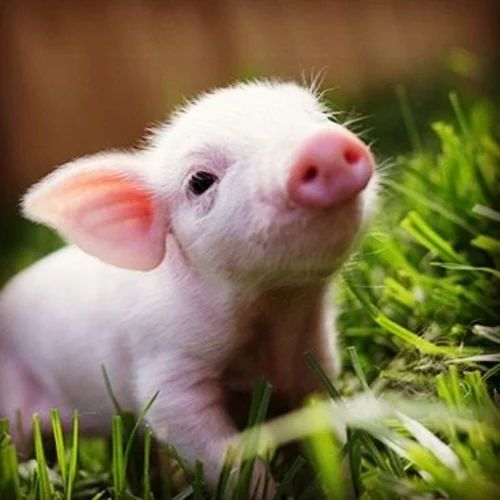

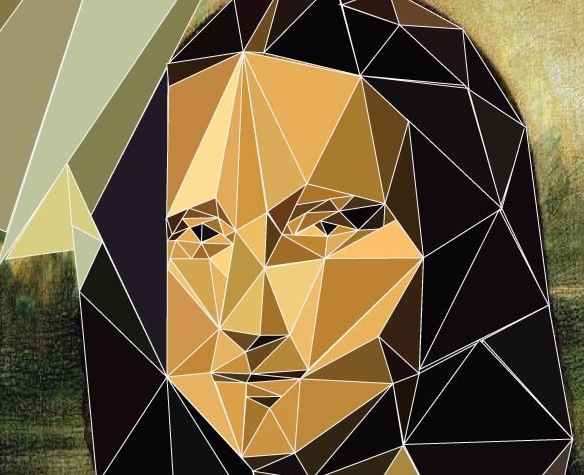

In [9]:
import os
import tensorflow as tf

# Set TensorFlow as the backend for Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from keras.utils import load_img, img_to_array, save_img, get_file
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
from IPython.display import Image, display

# File paths for base and style images
STYLE_IMAGE_URL = "https://mir-s3-cdn-cf.behance.net/project_modules/disp/60e85323876263.56048e4a42ad2.jpg"
BASE_IMAGE_URL = "https://5.imimg.com/data5/SELLER/Default/2022/12/SO/RK/HW/157640527/piglet-500x500.jpg"

BASE_IMAGE_PATH = get_file("piglet.jpg", BASE_IMAGE_URL)
STYLE_IMAGE_PATH = get_file("coubic.jpg", STYLE_IMAGE_URL)

OUTPUT_IMAGE_PREFIX = "pig_generated"

# Loss weights
TOTAL_VARIATION_WEIGHT = 1e-6
STYLE_LOSS_WEIGHT = 1e-6
CONTENT_LOSS_WEIGHT = 1.5e-8

# Define dimensions for the generated image
base_width, base_height = load_img(BASE_IMAGE_PATH).size
GENERATED_IMG_HEIGHT = 400
GENERATED_IMG_WIDTH = int(base_width * GENERATED_IMG_HEIGHT / base_height)

# Display input images
display(Image(BASE_IMAGE_PATH))
display(Image(STYLE_IMAGE_PATH))


# Image preprocessing utility
def load_and_process_image(image_path):
    """Load an image, resize it, and preprocess it for VGG19."""
    image = load_img(image_path, target_size=(GENERATED_IMG_HEIGHT, GENERATED_IMG_WIDTH))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    return tf.convert_to_tensor(vgg19.preprocess_input(image_array))


# Image postprocessing utility
def process_image_for_display(image_tensor):
    """Convert a tensor back to a valid image."""
    image_array = image_tensor.numpy().reshape((GENERATED_IMG_HEIGHT, GENERATED_IMG_WIDTH, 3))
    # Revert VGG19 preprocessing
    image_array[:, :, 0] += 103.939
    image_array[:, :, 1] += 116.779
    image_array[:, :, 2] += 123.68
    image_array = image_array[:, :, ::-1]  # Convert BGR to RGB
    return np.clip(image_array, 0, 255).astype("uint8")


# Gram matrix computation
def compute_gram_matrix(feature_map):
    """Calculate the Gram matrix of a feature map."""
    reshaped_features = tf.reshape(tf.transpose(feature_map, (2, 0, 1)), (tf.shape(feature_map)[2], -1))
    return tf.matmul(reshaped_features, tf.transpose(reshaped_features))


# Style loss function
def calculate_style_loss(style_features, generated_features):
    """Compute the style loss using Gram matrices."""
    style_gram = compute_gram_matrix(style_features)
    generated_gram = compute_gram_matrix(generated_features)
    num_channels = 3
    image_size = GENERATED_IMG_HEIGHT * GENERATED_IMG_WIDTH
    return tf.reduce_sum(tf.square(style_gram - generated_gram)) / (4.0 * (num_channels ** 2) * (image_size ** 2))


# Content loss function
def calculate_content_loss(base_features, generated_features):
    """Compute the content loss between two feature maps."""
    return tf.reduce_sum(tf.square(base_features - generated_features))


# Total variation loss function
def calculate_total_variation_loss(image_tensor):
    """Compute the total variation loss for smoothness."""
    horizontal_diff = tf.square(image_tensor[:, :-1, :-1, :] - image_tensor[:, 1:, :-1, :])
    vertical_diff = tf.square(image_tensor[:, :-1, :-1, :] - image_tensor[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(horizontal_diff + vertical_diff, 1.25))


# Define VGG19 feature extractor
def get_vgg19_feature_extractor():
    """Load VGG19 model for feature extraction."""
    model = vgg19.VGG19(weights="imagenet", include_top=False)
    return tf.keras.Model(inputs=model.inputs, outputs={layer.name: layer.output for layer in model.layers})


# Loss computation function
def compute_total_loss(generated_image, base_image, style_image, feature_extractor):
    """Compute total loss (content, style, and total variation)."""
    combined_input = tf.concat([base_image, style_image, generated_image], axis=0)
    extracted_features = feature_extractor(combined_input)

    total_loss = tf.zeros(shape=())

    # Content loss
    content_layer_output = extracted_features["block5_conv2"]
    base_content = content_layer_output[0]
    generated_content = content_layer_output[2]
    total_loss += CONTENT_LOSS_WEIGHT * calculate_content_loss(base_content, generated_content)

    # Style loss
    STYLE_LAYERS = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
    for layer_name in STYLE_LAYERS:
        style_features = extracted_features[layer_name][1]
        generated_features = extracted_features[layer_name][2]
        style_loss = calculate_style_loss(style_features, generated_features)
        total_loss += (STYLE_LOSS_WEIGHT / len(STYLE_LAYERS)) * style_loss

    # Total variation loss
    total_loss += TOTAL_VARIATION_WEIGHT * calculate_total_variation_loss(generated_image)
    return total_loss


# Compute loss and gradients
@tf.function
def compute_loss_and_gradients(generated_image, base_image, style_image, feature_extractor):
    """Compute gradients of the loss function."""
    with tf.GradientTape() as tape:
        loss = compute_total_loss(generated_image, base_image, style_image, feature_extractor)
    gradients = tape.gradient(loss, generated_image)
    return loss, gradients


# Optimization setup
learning_rate_schedule = ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
optimizer = SGD(learning_rate=learning_rate_schedule)

# Load images
base_image_tensor = load_and_process_image(BASE_IMAGE_PATH)
style_image_tensor = load_and_process_image(STYLE_IMAGE_PATH)
generated_image_tensor = tf.Variable(load_and_process_image(BASE_IMAGE_PATH))

# Initialize feature extractor
feature_extractor_model = get_vgg19_feature_extractor()

Iteration 1: Loss = 10632.19
Iteration 2: Loss = 10504.24
Iteration 3: Loss = 10332.42
Iteration 4: Loss = 10221.69
Iteration 5: Loss = 10064.52
Iteration 6: Loss = 9961.35
Iteration 7: Loss = 9821.05
Iteration 8: Loss = 9729.24
Iteration 9: Loss = 9594.51
Iteration 10: Loss = 9509.12


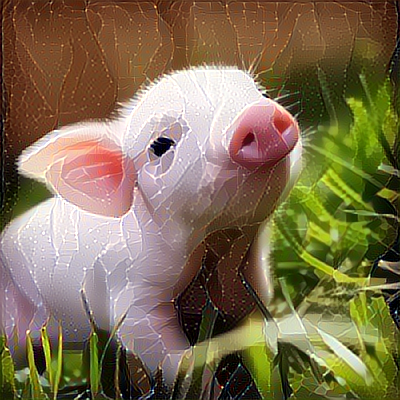

In [13]:
# Style transfer iterations
NUM_ITERATIONS = 10
for iteration in range(1, NUM_ITERATIONS + 1):
    loss, gradients = compute_loss_and_gradients(
        generated_image_tensor, base_image_tensor, style_image_tensor, feature_extractor_model
    )
    optimizer.apply_gradients([(gradients, generated_image_tensor)])

    # if iteration % 100 == 0:
    print(f"Iteration {iteration}: Loss = {loss:.2f}")
output_image = process_image_for_display(generated_image_tensor)
output_filename = f"{OUTPUT_IMAGE_PREFIX}_iteration_last.png"
save_img(output_filename, output_image)

# Display final image
final_image_path = f"{OUTPUT_IMAGE_PREFIX}_iteration_last.png"
display(Image(final_image_path))